This notebook demonstrates a hybrid detection pipeline (winding number to find defect candidates and CNN to filter out spurious defects) for analyzing 2D VTK vector field datasets. 

It utilizes the CNN model to classify features from vector field representations,
applies winding number calculations to candidate regions, and visualizes the processing results.
The workflow includes loading VTK files, pre-processing with custom utility functions, model
inference, and an interpretation of results using both tabular and graphical outputs.

This notebook tests the effectiveness of choosing the candidates with winding number or with order parameter

In [ ]:
import sys
import os
import numpy as np
import torch
sys.path.append(os.path.abspath(".."))
import utils.project_functions as pf
import utils.project_classes as pc
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label, center_of_mass
import vtk
import pandas as pd
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = pf.load_model(file_path="../Models/cnn_2025-08-12.pth")



## Test candidate selection with on a single frame

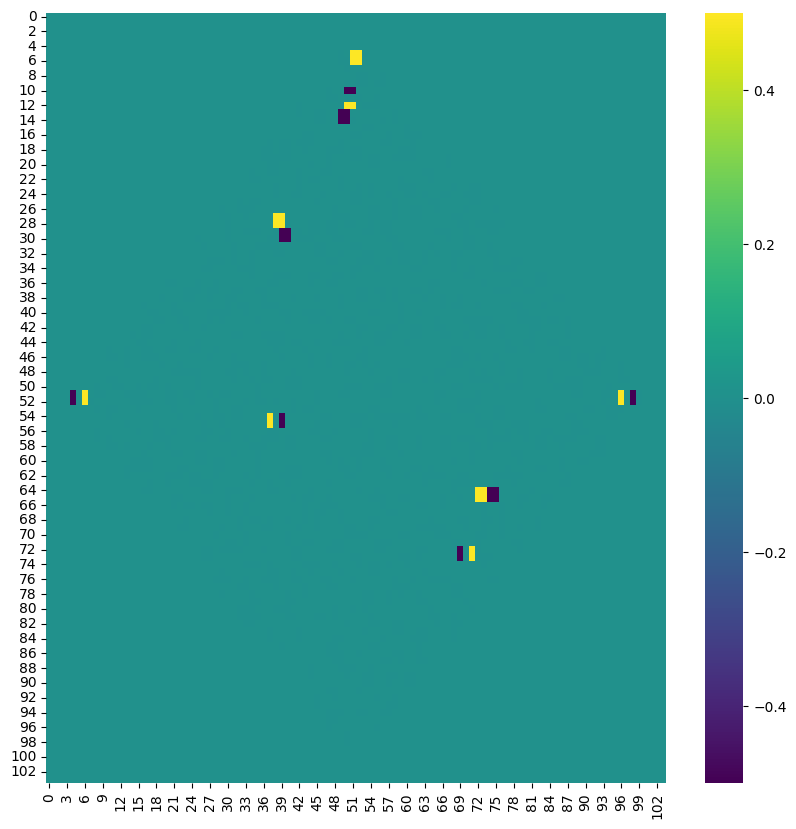

In [21]:
file_name = "../Data/MAI_U040_L_096_A/mpcd_175.vtk"

eigen_vals, eigen_vecs = pf.load_and_pad_vtk(file_name, pad_width=4)
winding_numbers, flips = pf.calculate_winding_number(eigen_vecs, pad_width=4)
winding_numbers *= -1

plt.figure(figsize=(10,10))
sns.heatmap(winding_numbers, cmap="viridis")
plt.show()


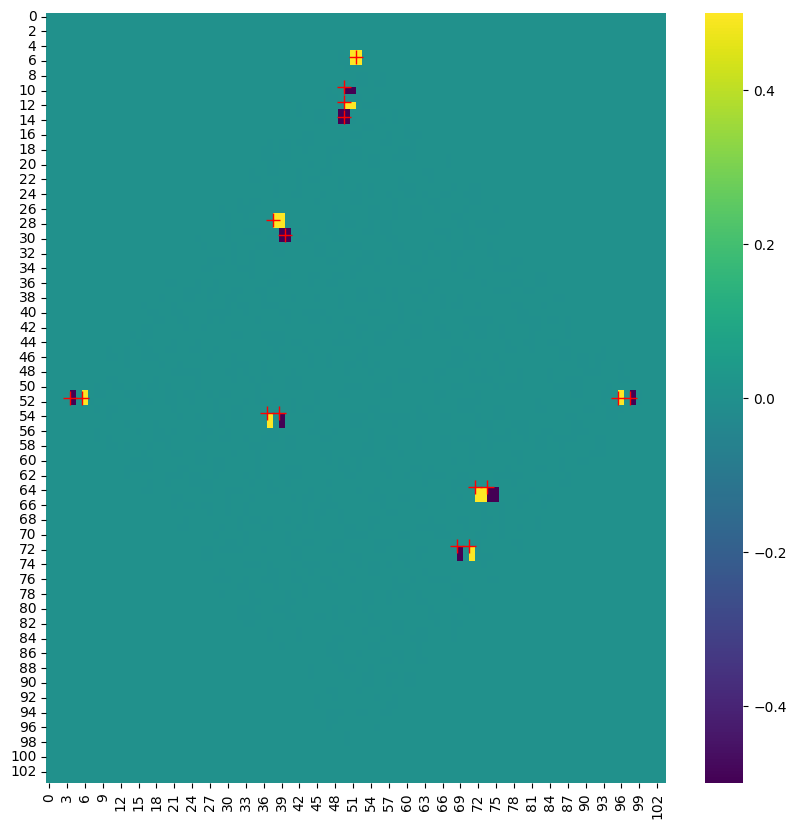

In [ ]:
# # Calculate centroids for each labeled region
centroids = pf.find_candidates_by_winding_number(winding_numbers)

# Plot original heatmap
plt.figure(figsize=(10,10))
sns.heatmap(winding_numbers, cmap="viridis")

# Overlay centroids
for centroid in centroids:
    plt.plot(centroid[1], centroid[0], 'r+', markersize=10)

plt.show()


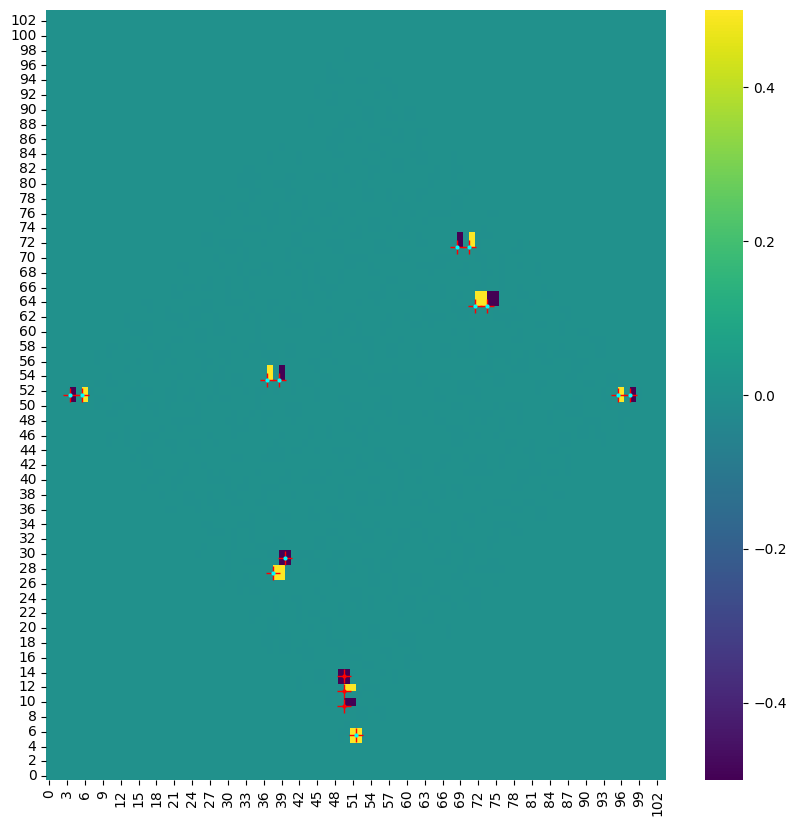

In [26]:
file_name = "../Data/MAI_U040_L_096_A/mpcd_175.vtk"

eigen_vals, eigen_vecs = pf.load_and_pad_vtk(file_name, pad_width=4)
winding_numbers, flips = pf.calculate_winding_number(eigen_vecs, pad_width=4)
winding_numbers *= -1

predictions_df = pd.DataFrame()
#defects = np.array([[i,j] for i in range(3,eigen_vals.shape[0]-3) for j in range(3,eigen_vals.shape[1]-3)])
defects = np.round([(c[1], c[0]) for c in centroids]).astype(int)
predictions = pf.predict_field(model, eigen_vals, eigen_vecs, defects, device=device, filename=f"w")
_x, _y = [sample.position[0] for sample in predictions], [sample.position[1] for sample in predictions]
_labels = [sample.pseudo_label for sample in predictions]
_confidence = [sample.pseudo_label_confidence for sample in predictions]
predictions_df= pd.DataFrame(list(zip(_x,_y, _labels, _confidence)),columns=["x","y","prediction","confidence"])
# predictions_df= predictions_df[predictions_df["prediction"]!=2]

# Plot original heatmap
plt.figure(figsize=(10,10))
sns.heatmap(winding_numbers, cmap="viridis")

# Overlay centroids
for centroid in centroids:
    plt.plot(centroid[1], centroid[0], 'r+', markersize=10)

# Overlay predictions
for index,row  in predictions_df.iterrows():
    plt.plot(row["x"], row["y"], 'o',markersize=2, color='blue' if row["prediction"]==0 else 'red' if row["prediction"]==1 else 'aqua')

plt.gca().invert_yaxis()

plt.show()


In [ ]:
predictions_df[predictions_df["prediction"]!=3]

# Count predictions for each label
label_counts = predictions_df['prediction'].value_counts().sort_index()
print("\nPrediction counts:")
for label, count in label_counts.items():
    print(f"Label {label}: {count}")


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assuming eigen_vecs, winding_numbers are already defined from the previous code

# Create meshgrid for quiver plot
x = np.arange(eigen_vecs.shape[0])
y = np.arange(eigen_vecs.shape[1])
X, Y = np.meshgrid(x, y)

# Extract x and y components of eigenvectors
U = eigen_vecs[:,:,0]
V = eigen_vecs[:,:,1]

# Create quiver plot with plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=X.flatten(),
    y=Y.flatten(),
    mode='markers',
    marker=dict(
        symbol='arrow',
        angle=90 + np.arctan2(V.flatten(), U.flatten()) * 180 / np.pi,
        size=16,  # Reduced size for better visualization
        color=winding_numbers.flatten(),
        colorscale='Viridis',
        colorbar=dict(title='Winding Number'),
        showscale=True
    ),
    name='Eigenvector Field',
    text=np.arctan2(V.flatten(), U.flatten()),
    hovertemplate='Angle: %{text:.2f}<extra></extra>'
))

fig.update_layout(
    title='Eigenvector Field with Winding Numbers',
    xaxis_title='X',
    yaxis_title='Y',
    width=800,
    height=800,
    yaxis=dict(autorange='reversed')
)

fig.show()



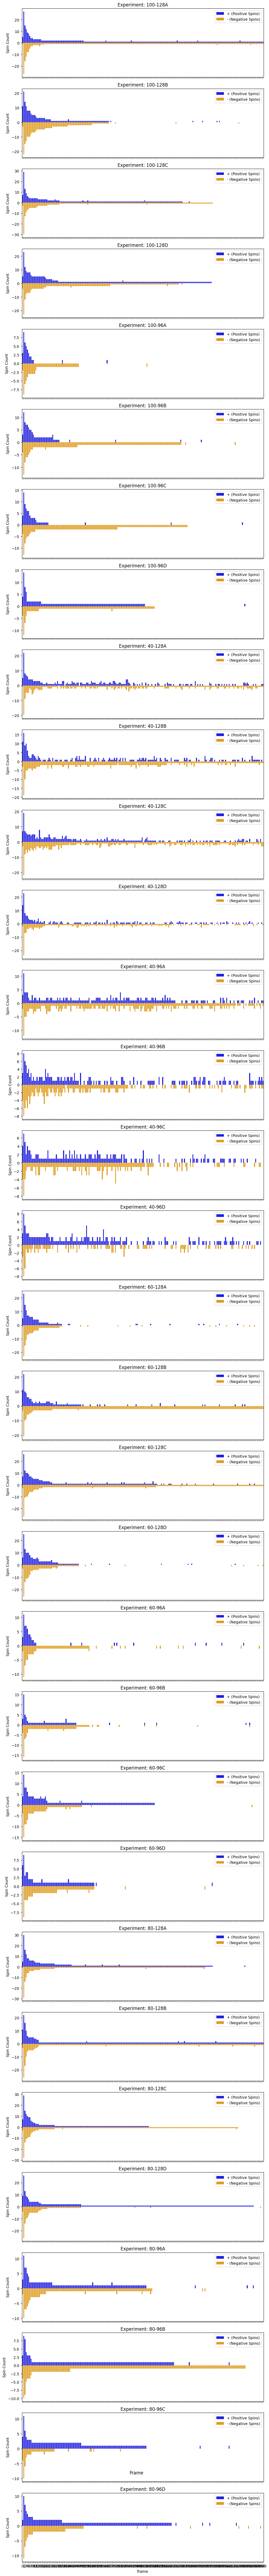

In [3]:
frames = range(0,200)
U = [100, 80, 60, 40]
L = [96, 128]
experiment = ["A", "B", "C", "D"]
file_name = "../Data/MAI_U{}_L_{}_{}/mpcd_{}.vtk"

predictions_df = pd.DataFrame(columns=["x","y","prediction","confidence","tag","frame"])

for u in U: 
    for l in L:
        for e in experiment:
            for frame in frames:
                try:
                    eigen_vals, eigen_vecs = pf.load_and_pad_vtk(file_name.format(str(u).zfill(3), str(l).zfill(3), e,  frame), pad_width=4)
                except:
                    print(f"File not found: {file_name.format(str(u).zfill(3), str(l).zfill(3), frame)}")
                    continue

                winding_numbers, flips = pf.calculate_winding_number(eigen_vecs, pad_width=4)
                winding_numbers *= -1

                centroids = pf.find_candidates_by_winding_number(winding_numbers)
                defects = np.round([(c[1], c[0]) for c in centroids]).astype(int)
                predictions = pf.predict_field(model, eigen_vals, eigen_vecs, defects, device=device, filename=f"w")
                _x, _y = [sample.position[0] for sample in predictions], [sample.position[1] for sample in predictions]
                _labels = [sample.pseudo_label for sample in predictions]
                _confidence = [sample.pseudo_label_confidence for sample in predictions]
                _tag = [f"{u}-{l}{e}" for _ in range(len(_x))]
                _frame = [frame for _ in range(len(_x))]

                predictions_df = pd.concat([predictions_df, pd.DataFrame(list(zip(_x,_y, _labels, _confidence, _tag, _frame )),columns=["x","y","prediction","confidence","tag","frame"])])

predictions_df["frame"] = predictions_df["frame"].astype(int)

pf.plot_experiments_evolution(predictions_df)


In [6]:
predictions_df.to_csv("../Predictions/predictions_02_04_25_002.csv")

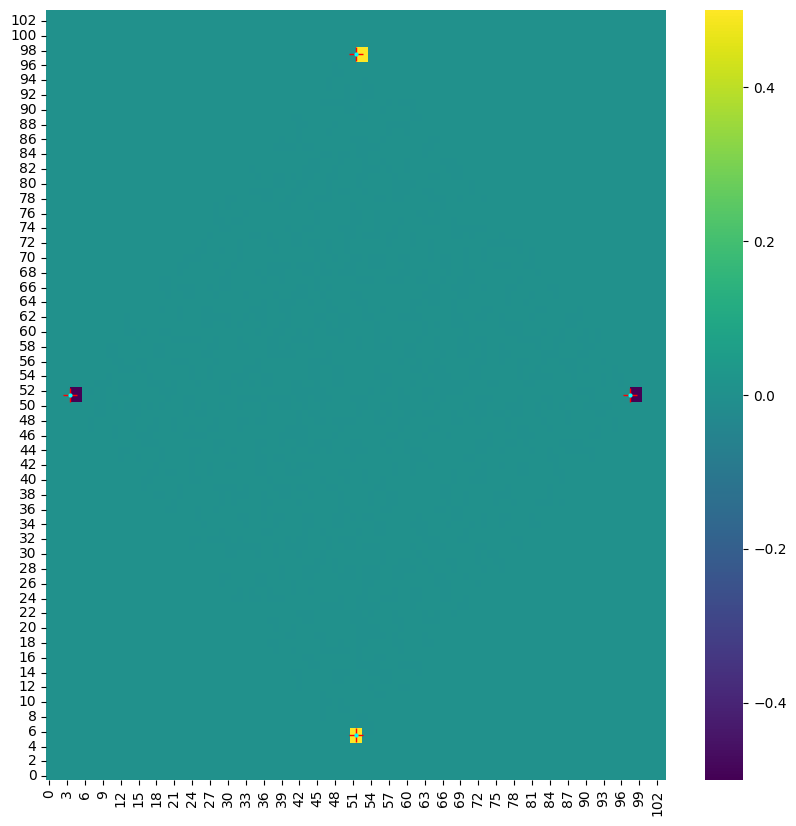

In [11]:
U=100
L=96
frame =50

file_name = "../Data/MAI_U{}_L_{}_A/mpcd_{}.vtk".format(str(U).zfill(3), str(L).zfill(3), frame)

eigen_vals, eigen_vecs = pf.load_and_pad_vtk(file_name, pad_width=4)
winding_numbers, flips = pf.calculate_winding_number(eigen_vecs, pad_width=4)
winding_numbers *= -1

centroids = pf.find_candidates_by_winding_number(winding_numbers)
predictions_df = pd.DataFrame()
defects = np.round([(c[1], c[0]) for c in centroids]).astype(int)
predictions = pf.predict_field(model, eigen_vals, eigen_vecs, defects, device=device, filename=f"w")
_x, _y = [sample.position[0] for sample in predictions], [sample.position[1] for sample in predictions]
_labels = [sample.pseudo_label for sample in predictions]
_confidence = [sample.pseudo_label_confidence for sample in predictions]
predictions_df= pd.DataFrame(list(zip(_x,_y, _labels, _confidence)),columns=["x","y","prediction","confidence"])
# predictions_df= predictions_df[predictions_df["prediction"]!=2]

# Plot original heatmap
plt.figure(figsize=(10,10))
sns.heatmap(winding_numbers, cmap="viridis")

# Overlay centroids
for centroid in centroids:
    plt.plot(centroid[1], centroid[0], 'r+', markersize=10)

# Overlay predictions
for index,row  in predictions_df.iterrows():
    plt.plot(row["x"], row["y"], 'o',markersize=2, color='blue' if row["prediction"]==0 else 'red' if row["prediction"]==1 else 'aqua')

plt.gca().invert_yaxis()

plt.show()

## Test with candidates obtained using the order parameter



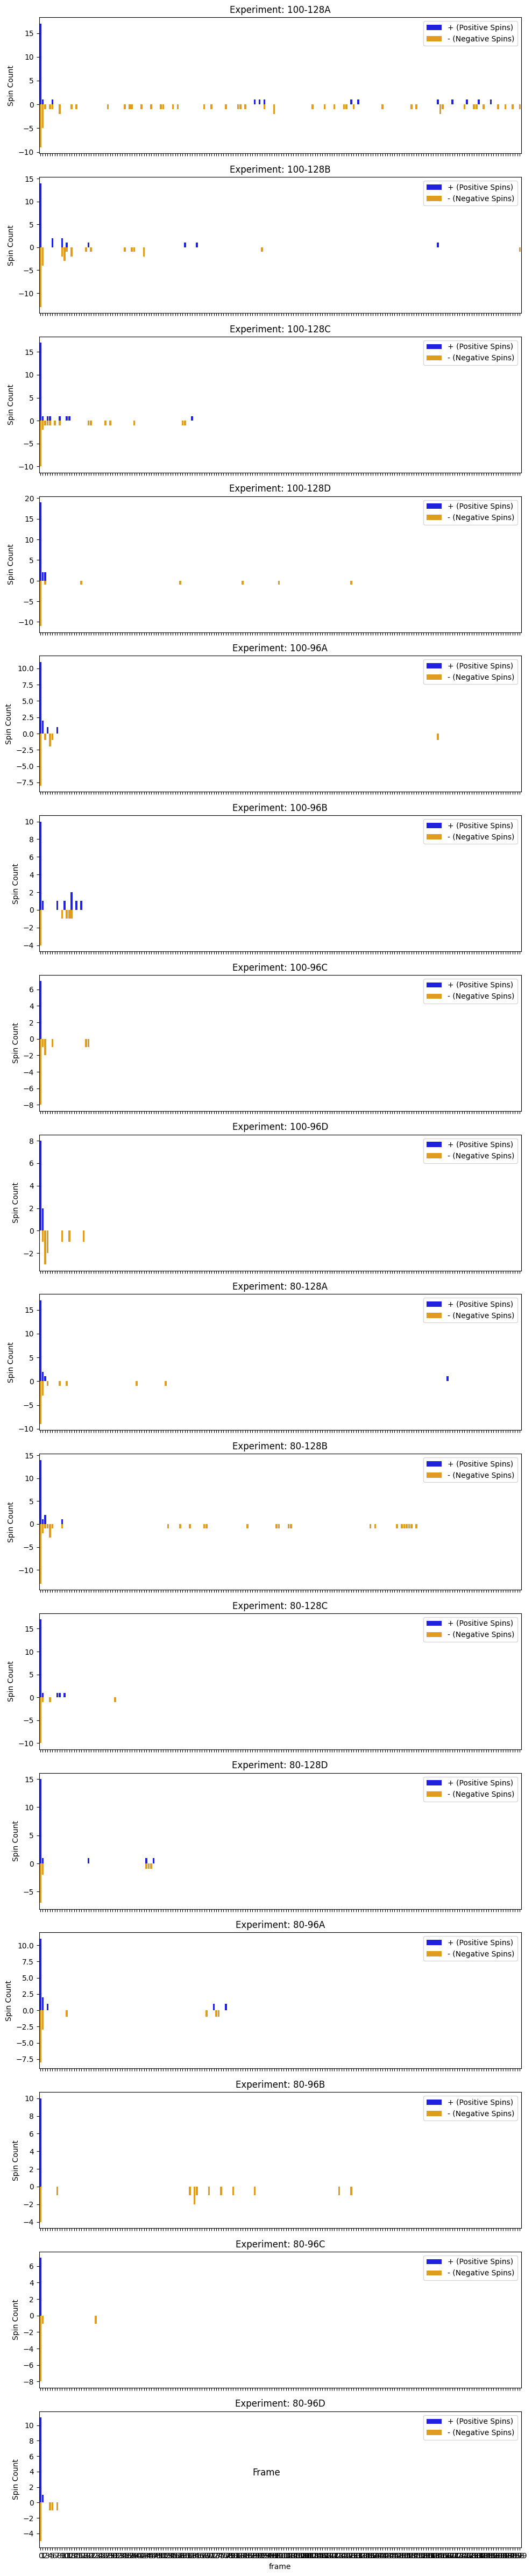

In [4]:
frames = range(0,200)
U = [100, 80]
L = [96, 128]
experiment = ["A", "B", "C", "D"]
file_name = "../Data/MAI_U{}_L_{}_{}/mpcd_{}.vtk"

model = pf.load_model(file_path="../Models/hybrid_03_04_25.pth")
predictions_df = pd.DataFrame(columns=["x","y","prediction","confidence","tag","frame"])

for u in U: 
    for l in L:
        for e in experiment:
            for frame in frames:
                try:
                    eigen_vals, eigen_vecs = pf.load_and_pad_vtk(file_name.format(str(u).zfill(3), str(l).zfill(3), e,  frame), pad_width=4)
                except:
                    print(f"File not found: {file_name.format(str(u).zfill(3), str(l).zfill(3), frame)}")
                    continue

                

                centroids = pf.find_defects(eigen_vals=eigen_vals, eigen_vecs=eigen_vecs, order_threshold=0.4)
                defects = np.round([(c[1], c[0]) for c in centroids]).astype(int)
                predictions = pf.predict_field(model, eigen_vals, eigen_vecs, defects, device=device, filename=f"w")
                _x, _y = [sample.position[0] for sample in predictions], [sample.position[1] for sample in predictions]
                _labels = [sample.pseudo_label for sample in predictions]
                _confidence = [sample.pseudo_label_confidence for sample in predictions]
                _tag = [f"{u}-{l}{e}" for _ in range(len(_x))]
                _frame = [frame for _ in range(len(_x))]

                predictions_df = pd.concat([predictions_df, pd.DataFrame(list(zip(_x,_y, _labels, _confidence, _tag, _frame )),columns=["x","y","prediction","confidence","tag","frame"])])

predictions_df["frame"] = predictions_df["frame"].astype(int)

pf.plot_experiments_evolution(predictions_df)
